# Fine Tuning

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import cv2
from google.colab import drive
import random
from datetime import datetime

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS_STAGE1 = 50  # Stage 1: Individual teeth (gunakan setting Anda)
EPOCHS_STAGE2 = 30  # Stage 2: Transfer ke panoramic
LEARNING_RATE_STAGE1 = 0.00001

In [ ]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [ ]:
# Konfigurasi path data
BASE_DIR = '/content/drive/MyDrive/TA/dt2'
INDIVIDUAL_DIR = os.path.join(BASE_DIR, 'individual')
PANORAMIC_DIR = os.path.join(BASE_DIR, 'panoramik')
RESULTS_DIR = os.path.join(BASE_DIR, 'hasil')

#Preprocessing Data 1

In [ ]:
# Data generators untuk individual teeth dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
# Load data individual teeth
train_generator_stage1 = train_datagen.flow_from_directory(
    INDIVIDUAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator_stage1 = validation_datagen.flow_from_directory(
    INDIVIDUAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

Found 501 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [ ]:
print(f"   Training samples: {train_generator_stage1.samples}")
print(f"   Validation samples: {validation_generator_stage1.samples}")

   Training samples: 501
   Validation samples: 124


# Building Model 1

In [ ]:
model_stage1 = models.Sequential([
    # Arsitektur CNN yang sama persis dengan code Anda
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_stage1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
print("📋 Stage 1 Model Summary:")
model_stage1.summary()

📋 Stage 1 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
early_stopping_stage1 = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

checkpoint_stage1 = ModelCheckpoint(
    filepath=os.path.join(RESULTS_DIR, 'stage1_individual_best.h5'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
# Melatih model
print("\n🎯 MULAI TRAINING TAHAP 1...")

history_stage1 = model_stage1.fit(
    train_generator_stage1,
    epochs=EPOCHS_STAGE1,
    validation_data=validation_generator_stage1,
    callbacks=[early_stopping_stage1, checkpoint_stage1]
)



🎯 MULAI TRAINING TAHAP 1...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5159 - loss: 1.0167
Epoch 1: val_accuracy improved from -inf to 0.38710, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.5176 - loss: 1.0132 - val_accuracy: 0.3871 - val_loss: 0.6952
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5943 - loss: 0.8258
Epoch 2: val_accuracy improved from 0.38710 to 0.41129, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - accuracy: 0.5947 - loss: 0.8243 - val_accuracy: 0.4113 - val_loss: 0.6936
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5903 - loss: 0.7764
Epoch 3: val_accuracy improved from 0.41129 to 0.61290, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.5916 - loss: 0.7759 - val_accuracy: 0.6129 - val_loss: 0.6881
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6162 - loss: 0.7637
Epoch 4: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.6166 - loss: 0.7625 - val_accuracy: 0.3871 - val_loss: 0.6981
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6575 - loss: 0.7041
Epoch 5: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.6572 - loss: 0.7026 - val_accuracy: 0.6129 - val_loss: 0.6830
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6420 - loss: 0.6850
Epoch 6: val_accuracy did not improve from 0.61290
16/16 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.6427 - loss: 0.6854 - val_accuracy: 0.6129 - val_loss: 0.6759
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6764 - loss: 0.6354
Epoch 7: val_accuracy did not improve from 0.61290


16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.7486 - loss: 0.5500 - val_accuracy: 0.6210 - val_loss: 0.7872
Epoch 28/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6836 - loss: 0.5877
Epoch 28: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.6841 - loss: 0.5870 - val_accuracy: 0.6210 - val_loss: 0.8812
Epoch 29/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7249 - loss: 0.5625
Epoch 29: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.7241 - loss: 0.5627 - val_accuracy: 0.6129 - val_loss: 0.8448
Epoch 30/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7221 - loss: 0.5239
Epoch 30: val_accuracy did not improve from 0.62097
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.7229 - loss: 0.5235 - val_accuracy: 0.6129 - val_loss: 0.7974
Epoch 31/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7185 - loss: 0.5872
Epoch 31: val_accuracy did not improve from 

16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.6959 - loss: 0.6160 - val_accuracy: 0.6371 - val_loss: 0.6539
Epoch 34/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7234 - loss: 0.5552
Epoch 34: val_accuracy did not improve from 0.63710
16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.7239 - loss: 0.5550 - val_accuracy: 0.6371 - val_loss: 0.6638
Epoch 35/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7770 - loss: 0.4929
Epoch 35: val_accuracy improved from 0.63710 to 0.64516, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.7757 - loss: 0.4943 - val_accuracy: 0.6452 - val_loss: 0.6405
Epoch 36/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7054 - loss: 0.5826
Epoch 36: val_accuracy improved from 0.64516 to 0.71774, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.7059 - loss: 0.5818 - val_accuracy: 0.7177 - val_loss: 0.5626
Epoch 37/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7611 - loss: 0.5137
Epoch 37: val_accuracy did not improve from 0.71774
16/16 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.7603 - loss: 0.5151 - val_accuracy: 0.7177 - val_loss: 0.5679
Epoch 38/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7601 - loss: 0.4779
Epoch 38: val_accuracy did not improve from 0.71774
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.7590 - loss: 0.4805 - val_accuracy: 0.7016 - val_loss: 0.5917
Epoch 39/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7256 - loss: 0.6200
Epoch 39: val_accuracy improved from 0.71774 to 0.72581, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 124s 8s/step - accuracy: 0.7251 - loss: 0.6191 - val_accuracy: 0.7258 - val_loss: 0.5570
Epoch 40/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7295 - loss: 0.5358
Epoch 40: val_accuracy did not improve from 0.72581
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.7301 - loss: 0.5347 - val_accuracy: 0.7177 - val_loss: 0.5445
Epoch 41/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7385 - loss: 0.5290
Epoch 41: val_accuracy improved from 0.72581 to 0.75000, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.7378 - loss: 0.5297 - val_accuracy: 0.7500 - val_loss: 0.5233
Epoch 42/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7343 - loss: 0.5388
Epoch 42: val_accuracy did not improve from 0.75000
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.7356 - loss: 0.5366 - val_accuracy: 0.7419 - val_loss: 0.5466
Epoch 43/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7611 - loss: 0.5206
Epoch 43: val_accuracy improved from 0.75000 to 0.75806, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.7598 - loss: 0.5223 - val_accuracy: 0.7581 - val_loss: 0.5200
Epoch 44/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7219 - loss: 0.5927
Epoch 44: val_accuracy did not improve from 0.75806
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.7217 - loss: 0.5913 - val_accuracy: 0.7339 - val_loss: 0.5127
Epoch 45/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7210 - loss: 0.5403
Epoch 45: val_accuracy did not improve from 0.75806
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.7216 - loss: 0.5403 - val_accuracy: 0.7581 - val_loss: 0.4946
Epoch 46/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7538 - loss: 0.5197
Epoch 46: val_accuracy did not improve from 0.75806
16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - accuracy: 0.7545 - loss: 0.5185 - val_accuracy: 0.7581 - val_loss: 0.4940
Epoch 47/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7572 - loss: 0.5204
Epoch 47: val_accuracy improved from 0.75806

16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.7572 - loss: 0.5191 - val_accuracy: 0.7661 - val_loss: 0.4751
Epoch 48/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7546 - loss: 0.4986
Epoch 48: val_accuracy improved from 0.76613 to 0.79032, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 122s 8s/step - accuracy: 0.7551 - loss: 0.4986 - val_accuracy: 0.7903 - val_loss: 0.4643
Epoch 49/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7204 - loss: 0.5857
Epoch 49: val_accuracy did not improve from 0.79032
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.7216 - loss: 0.5823 - val_accuracy: 0.7661 - val_loss: 0.4781
Epoch 50/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7482 - loss: 0.4796
Epoch 50: val_accuracy did not improve from 0.79032
16/16 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.7488 - loss: 0.4815 - val_accuracy: 0.7661 - val_loss: 0.4842


In [ ]:
# Hasil Stage 1
best_val_acc_idx_stage1 = np.argmax(history_stage1.history['val_accuracy'])
best_train_acc_stage1 = history_stage1.history['accuracy'][best_val_acc_idx_stage1]
best_val_acc_stage1 = history_stage1.history['val_accuracy'][best_val_acc_idx_stage1]
best_epoch_stage1 = best_val_acc_idx_stage1 + 1

print(f"\n✅ HASIL STAGE 1 (Individual Teeth):")
print(f"🎯 Epoch terbaik: {best_epoch_stage1}")
print(f"📈 Akurasi training terbaik: {best_train_acc_stage1:.4f}")
print(f"📈 Akurasi validasi terbaik: {best_val_acc_stage1:.4f}")


✅ HASIL STAGE 1 (Individual Teeth):
🎯 Epoch terbaik: 48
📈 Akurasi training terbaik: 0.7625
📈 Akurasi validasi terbaik: 0.7903


# Prepocessing Data 2

In [ ]:
model_stage1.load_weights(os.path.join(RESULTS_DIR, 'stage1_individual_best.h5'))
print(f"✅ Loaded best model from Stage 1 (accuracy: {best_val_acc_stage1:.4f})")


✅ Loaded best model from Stage 1 (accuracy: 0.7903)


In [ ]:
# Data generators untuk panoramik (lebih konservatif)
panoramic_train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # Augmentasi lebih konservatif untuk panoramic
    rotation_range=10,  # Kurangi dari 20
    width_shift_range=0.1,  # Kurangi dari 0.2
    height_shift_range=0.1,
    zoom_range=0.1,
    # Hapus horizontal_flip untuk panoramic
    fill_mode='nearest'
)

panoramic_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
# Load data panoramik
if os.path.exists(PANORAMIC_DIR):
    train_generator_stage2 = panoramic_train_datagen.flow_from_directory(
        PANORAMIC_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True,
        seed=42
    )

    validation_generator_stage2 = panoramic_val_datagen.flow_from_directory(
        PANORAMIC_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False,
        seed=42
    )

    print(f"✅ Data loaded - Stage 2:")
    print(f"   Training samples: {train_generator_stage2.samples}")
    print(f"   Validation samples: {validation_generator_stage2.samples}")

    # Calculate class weights for panoramic
    class_weights_stage2 = compute_class_weight(
        'balanced',
        classes=np.unique(train_generator_stage2.classes),
        y=train_generator_stage2.classes
    )
    class_weight_dict_stage2 = {i: class_weights_stage2[i] for i in range(len(class_weights_stage2))}
    print(f"⚖️ Class weights Stage 2: {class_weight_dict_stage2}")

else:
    print(f"❌ Folder panoramic tidak ditemukan: {PANORAMIC_DIR}")
    print("⚠️  Silakan sesuaikan path PANORAMIC_DIR")

Found 429 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
✅ Data loaded - Stage 2:
   Training samples: 429
   Validation samples: 107
⚖️ Class weights Stage 2: {0: np.float64(1.247093023255814), 1: np.float64(0.8346303501945526)}


In [ ]:
print(f"   Training samples: {train_generator_stage2.samples}")
print(f"   Validation samples: {validation_generator_stage2.samples}")

   Training samples: 429
   Validation samples: 107


# Building Model 2

In [ ]:
print(f"\n🔧 Fine-tuning untuk panoramic...")
print(f"   Learning Rate Stage 1: {LEARNING_RATE_STAGE1}")
print(f"   Learning Rate Stage 2: {LEARNING_RATE_STAGE1 * 0.01}")


🔧 Fine-tuning untuk panoramic...
   Learning Rate Stage 1: 1e-05
   Learning Rate Stage 2: 1.0000000000000001e-07


In [ ]:
# Fine-tuning: Compile ulang dengan learning rate lebih rendah
model_stage1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE1 * 0.01),  # LR 10x lebih kecil
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks untuk Stage 2
early_stopping_stage2 = EarlyStopping(
    monitor='val_accuracy',
    patience=30,  # Lebih ketat
    restore_best_weights=True,
    verbose=1
)

checkpoint_stage2 = ModelCheckpoint(
    filepath=os.path.join(RESULTS_DIR, 'stage2_panoramic_best.h5'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
print("\n🎯 MULAI TRAINING TAHAP 2...")

history_stage2 = model_stage1.fit(
        train_generator_stage2,
        epochs=EPOCHS_STAGE2,
        validation_data=validation_generator_stage2,
        callbacks=[early_stopping_stage2, checkpoint_stage2],
        class_weight=class_weight_dict_stage2
    )


🎯 MULAI TRAINING TAHAP 2...
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4734 - loss: 0.7843
Epoch 1: val_accuracy improved from -inf to 0.64486, saving model to /content/drive/MyDrive/TA/dt2/hasil/stage2_panoramic_best.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.4751 - loss: 0.7834 - val_accuracy: 0.6449 - val_loss: 0.6533
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5191 - loss: 0.8009
Epoch 2: val_accuracy did not improve from 0.64486
14/14 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.5209 - loss: 0.7980 - val_accuracy: 0.6449 - val_loss: 0.6540
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5549 - loss: 0.7576
Epoch 3: val_accuracy did not improve from 0.64486
14/14 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.5550 - loss: 0.7569 - val_accuracy: 0.6355 - val_loss: 0.6535
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6046 - loss: 0.7200
Epoch 4: val_accuracy did not improve from 0.64486
14/14 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - accuracy: 0.6016 - loss: 0.7232 - val_accuracy: 0.6355 - val_loss: 0.6537
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5309 - loss: 0.7623
Epoch 5: val_accuracy did not improve from 0.64486
1

14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.5188 - loss: 0.7959 - val_accuracy: 0.6542 - val_loss: 0.6559
Epoch 28/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5389 - loss: 0.7555
Epoch 28: val_accuracy did not improve from 0.65421
14/14 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.5387 - loss: 0.7550 - val_accuracy: 0.6355 - val_loss: 0.6562
Epoch 29/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4913 - loss: 0.8021
Epoch 29: val_accuracy did not improve from 0.65421
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.4937 - loss: 0.8001 - val_accuracy: 0.6355 - val_loss: 0.6568
Epoch 30/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4774 - loss: 0.7796
Epoch 30: val_accuracy did not improve from 0.65421
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.4792 - loss: 0.7778 - val_accuracy: 0.6449 - val_loss: 0.6565
Restoring model weights from the end of the best epoch: 27.


In [ ]:
best_val_acc_idx_stage2 = np.argmax(history_stage2.history['val_accuracy'])
best_train_acc_stage2 = history_stage2.history['accuracy'][best_val_acc_idx_stage2]
best_val_acc_stage2 = history_stage2.history['val_accuracy'][best_val_acc_idx_stage2]
best_epoch_stage2 = best_val_acc_idx_stage2 + 1

print(f"\n✅ HASIL STAGE 2 (Panoramic Transfer):")
print(f"🎯 Epoch terbaik: {best_epoch_stage2}")
print(f"📈 Akurasi training terbaik: {best_train_acc_stage2:.4f}")
print(f"📈 Akurasi validasi terbaik: {best_val_acc_stage2:.4f}")


✅ HASIL STAGE 2 (Panoramic Transfer):
🎯 Epoch terbaik: 27
📈 Akurasi training terbaik: 0.5548
📈 Akurasi validasi terbaik: 0.6542


#Evaluation

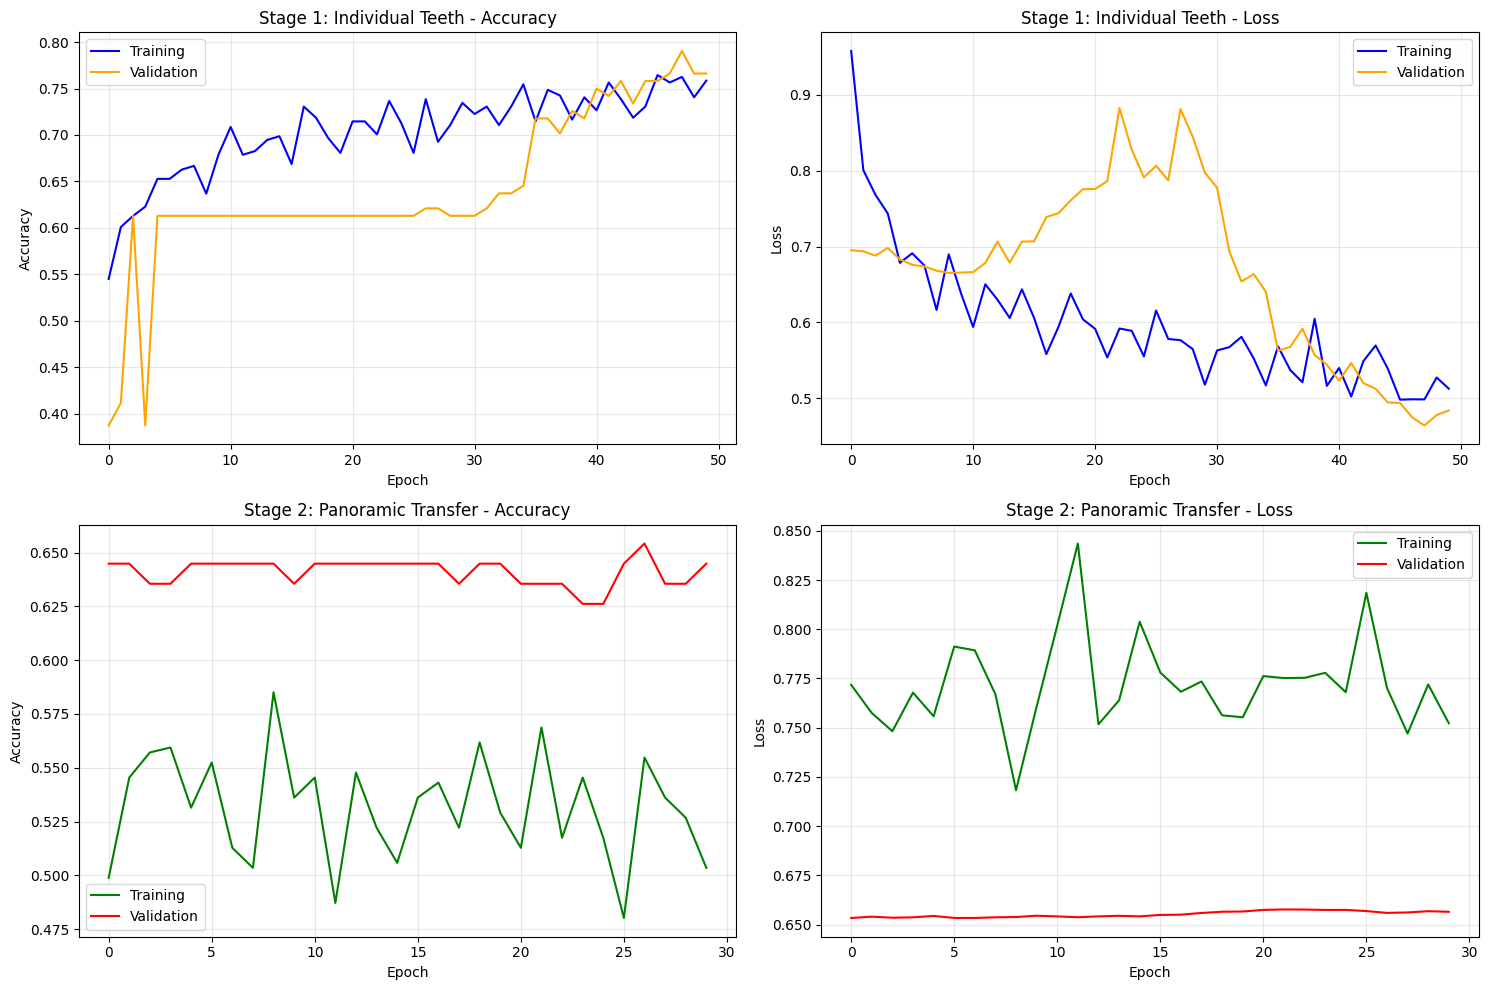

In [ ]:
# Training History
plt.figure(figsize=(15, 10))

# Stage 1 plots
plt.subplot(2, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Training', color='blue')
plt.plot(history_stage1.history['val_accuracy'], label='Validation', color='orange')
plt.title('Stage 1: Individual Teeth - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history_stage1.history['loss'], label='Training', color='blue')
plt.plot(history_stage1.history['val_loss'], label='Validation', color='orange')
plt.title('Stage 1: Individual Teeth - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Stage 2 plots
plt.subplot(2, 2, 3)
plt.plot(history_stage2.history['accuracy'], label='Training', color='green')
plt.plot(history_stage2.history['val_accuracy'], label='Validation', color='red')
plt.title('Stage 2: Panoramic Transfer - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(history_stage2.history['loss'], label='Training', color='green')
plt.plot(history_stage2.history['val_loss'], label='Validation', color='red')
plt.title('Stage 2: Panoramic Transfer - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'hierarchical_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model_stage1.load_weights(os.path.join(RESULTS_DIR, 'stage2_panoramic_best.h5'))

In [ ]:
# Evaluasi model pada data validasi
validation_generator_stage2.reset()
y_pred_probs = model_stage1.predict(validation_generator_stage2)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator_stage2.classes

3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


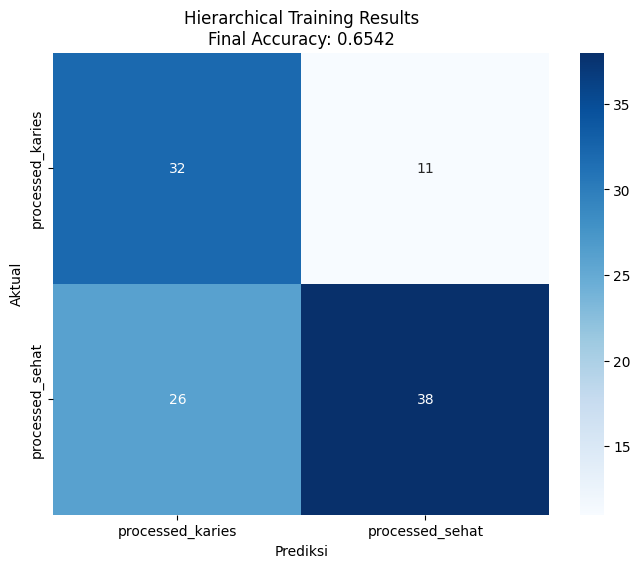

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(validation_generator_stage2.class_indices.keys()),
                yticklabels=list(validation_generator_stage2.class_indices.keys()))
plt.title(f'Hierarchical Training Results\nFinal Accuracy: {best_val_acc_stage2:.4f}')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig(os.path.join(RESULTS_DIR, 'final_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Classification Report
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(
        y_true,
        y_pred,
        target_names=list(validation_generator_stage2.class_indices.keys())
    ))


📋 CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

processed_karies       0.55      0.74      0.63        43
 processed_sehat       0.78      0.59      0.67        64

        accuracy                           0.65       107
       macro avg       0.66      0.67      0.65       107
    weighted avg       0.69      0.65      0.66       107



In [ ]:
# Menyimpan model final
model_stage1.save(os.path.join(RESULTS_DIR, 'hierarchical_final_model.h5'))

In [ ]:
print(f"\n💾 MODELS SAVED:")
print(f"📁 Stage 1: {RESULTS_DIR}/stage1_individual_best.h5")
print(f"📁 Stage 2: {RESULTS_DIR}/stage2_panoramic_best.h5")
print(f"📁 Final: {RESULTS_DIR}/hierarchical_final_model.h5")



💾 MODELS SAVED:
📁 Stage 1: /content/drive/MyDrive/TA/dt2/hasil/stage1_individual_best.h5
📁 Stage 2: /content/drive/MyDrive/TA/dt2/hasil/stage2_panoramic_best.h5
📁 Final: /content/drive/MyDrive/TA/dt2/hasil/hierarchical_final_model.h5


In [ ]:
if best_val_acc_stage2 >= 0.85:
        print(f"\n🏆 EXCELLENT! Model performance sangat baik (≥85%)")
        print(f"✅ Siap untuk deployment dan testing lebih lanjut")
elif best_val_acc_stage2 >= 0.80:
        print(f"\n🥇 VERY GOOD! Model performance baik (≥80%)")
        print(f"✅ Dapat digunakan dengan confidence tinggi")
elif best_val_acc_stage2 >= 0.75:
        print(f"\n🥈 GOOD! Model performance cukup baik (≥75%)")
        print(f"⚠️  Mungkin butuh fine-tuning tambahan")
else:
        print(f"\n⚠️  Model butuh improvement lebih lanjut")


⚠️  Model butuh improvement lebih lanjut
